### a) Construcción de Dataframe

In [1]:
import pandas as pd
df = pd.read_csv('text_emotion.csv')
print df.head()

print list(df.columns.values)
registros,atributos = df.shape
print "Cantidad de registros",registros
print "Cantidad de atributos",atributos

     tweet_id   sentiment       author  \
0  1956967341       empty   xoshayzers   
1  1956967666     sadness    wannamama   
2  1956967696     sadness    coolfunky   
3  1956967789  enthusiasm  czareaquino   
4  1956968416     neutral    xkilljoyx   

                                             content  
0  @tiffanylue i know  i was listenin to bad habi...  
1  Layin n bed with a headache  ughhhh...waitin o...  
2                Funeral ceremony...gloomy friday...  
3               wants to hang out with friends SOON!  
4  @dannycastillo We want to trade with someone w...  
['tweet_id', 'sentiment', 'author', 'content']
Cantidad de registros 40000
Cantidad de atributos 4


Este dataset consta de 40000 tweets, cada tweet tiene una id asociada,  una emoción mutuamente excluyente con las demás, el autor y el texto.

In [2]:
def clase_ocurrencia(df,campo):
    clases = {}
    for index,row in df.iterrows():
        if row[campo] not in clases.keys():
                clases[row[campo]] = 1
        else:
            clases[row[campo]] += 1
    return clases

emotions = clase_ocurrencia(df,'sentiment')
print "Clases y la cantidad de registros por clases"
print emotions




Clases y la cantidad de registros por clases
{'love': 3842, 'relief': 1526, 'neutral': 8638, 'anger': 110, 'sadness': 5165, 'empty': 827, 'surprise': 2187, 'fun': 1776, 'enthusiasm': 759, 'happiness': 5209, 'hate': 1323, 'worry': 8459, 'boredom': 179}


### b) Construcción de conjuntos

In [3]:
import numpy as np
msk = np.random.rand(len(df)) < 0.8
print msk
df_train = df[msk]
df_test = df[~msk]
print(len(df_train))
print(len(df_test))

[ True  True  True ...,  True False  True]
31866
8134


### c) Pre procesamiento 

Para aumentar la eficacia de las caracterı́sticas extraı́das es conveniente ejecutar algunas técnicas de pre-
procesamiento básicas como: pasar todo el texto a minúsculas (lower-casing), eliminar signos de puntuación
y eliminar palabras sin significado como artı́culos, pronombres y preposiciones (stop word removal [9]). Otra
técnica que suele ser útil para obtener buenas caracterı́sticas (features) es la lematización [11], es decir la
reducción de todas las palabras a su tronco léxico base. Una técnica similar y más utilizada en la práctica es
el stemming [10]. Varias de éstas están implementadas en la libreria nltk [13] para python.

In [4]:
X_train = np.array(df_train['content'])
y_train = np.array(df_train['sentiment'])
X_test = np.array(df_test['content'])
y_test = np.array(df_test['sentiment'])

from nltk.tokenize import TweetTokenizer
from nltk.corpus import stopwords
import re 
other_stopwords = ['...','.','!',' ',';',',']
stoplist = np.concatenate((stopwords.words('english'),other_stopwords),axis=0)
tknzr = TweetTokenizer(strip_handles=True, reduce_len=True)

#Preprocesamiento

for i in range(len(X_train)):
    X_train[i] = tknzr.tokenize(X_train[i]) 
    X_train[i] = [token.lower() for token in X_train[i]] 
    X_train[i] = [re.sub(r'http\S+', '',token) for token in X_train[i] if token not in stoplist]
    X_train[i] = [token for token in X_train[i] if len(token)>2]


for i in range(len(X_test)):
    X_test[i] = tknzr.tokenize(X_test[i]) 
    X_test[i] = [token.lower() for token in X_test[i]] 
    X_test[i] = [re.sub(r'http\S+', '',token) for token in X_test[i] if token not in stoplist]
    X_test[i] = [token for token in X_test[i] if len(token)>2]
    




In [5]:
palabras = {}
for tweet in X_train:
    for word in tweet:
        if word not in palabras.keys():
            palabras[word] = 1
        else:
            palabras[word] += 1

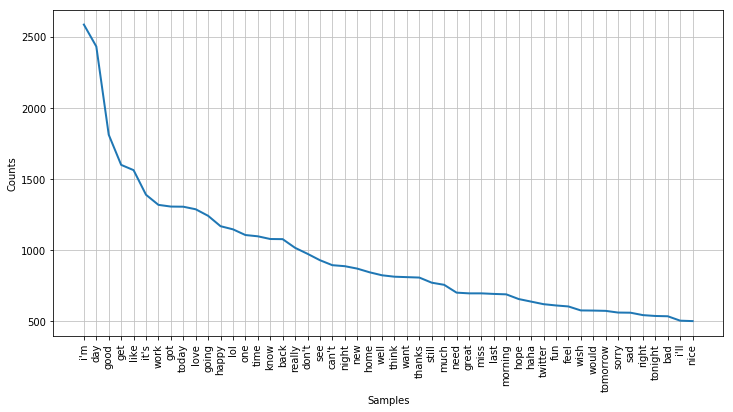

In [6]:
import nltk
import matplotlib.pyplot as plt
fdist = nltk.FreqDist(palabras)
plt.figure(figsize=(12,6))
fdist.plot(50)

### d ) Criterio para un problema binario

In [7]:
# Criterio por ahora, neutral positivo,
# empty y surprise negativo, ( Para dejar medianamente balanceado los datos)

positivas = ['love','relief','fun','enthusiasm','happiness','neutral']
negativas = ['anger','sadness','hate','worry','boredom','empty','surprise']

pos = 0
for key in emotions:
    if key in positivas:
        pos += emotions[key]
print pos 

neg = 0
for key in emotions:
    if key in negativas:
        neg += emotions[key]
print neg

emotions_l = np.concatenate((negativas,positivas),axis=0)
print emotions_l
#6,-6
emotions = {}
count = -7
for em in range(len(emotions_l)):
    emotions[emotions_l[em]] = str(count+1)
    count += 1
print emotions

21750
18250
['anger' 'sadness' 'hate' 'worry' 'boredom' 'empty' 'surprise' 'love'
 'relief' 'fun' 'enthusiasm' 'happiness' 'neutral']
{'love': '1', 'neutral': '6', 'fun': '3', 'sadness': '-5', 'boredom': '-2', 'worry': '-3', 'enthusiasm': '4', 'anger': '-6', 'surprise': '0', 'happiness': '5', 'hate': '-4', 'empty': '-1', 'relief': '2'}


In [8]:
def codificar_emotions(arreglo):
    nuevo_arreglo = []
    for i in range(len(arreglo)):
        nuevo_arreglo.append(emotions[arreglo[i]])
    return nuevo_arreglo

#Arreglos decodificados
y_train_em = codificar_emotions(y_train)
y_test_em =  codificar_emotions(y_test)


In [9]:
def codificar(arreglo):
    for i in range(len(arreglo)):
        if arreglo[i] in positivas:
            arreglo[i] = "1"
        else:
            arreglo[i] = "-1"
    return arreglo
y_train = codificar(y_train)
y_test = codificar(y_test)

### e) Representación de documentos

In [14]:
print X_train[:2]

[ list([u'know', u'listenin', u'bad', u'habit', u'earlier', u'started', u'freakin', u'part'])
 list([u'layin', u'bed', u'headache', u'ughhh', u'waitin', u'call'])]


In [10]:
from sklearn.feature_extraction.text import TfidfVectorizer
# Usando TfidfVectorizer
vectorizer = TfidfVectorizer()
X_tweets1 = []
X_tweets2 = []
for i in range(len(X_train)):
    X_tweets1.append((" ").join(X_train[i]))
for i in range(len(X_test)):
    X_tweets2.append((" ").join(X_test[i]))
X_train_tfidf = vectorizer.fit_transform(X_tweets1) # Le damos el vocabulario de entrenamiento!
X_test_tfidf = vectorizer.transform(X_tweets2)

Aquí entrenamos con el conjunto de entrenamiento y luego transformamos el conjunto de test en base al diccionario generado.

Ojo, hay que tener un buen diccionario para poder generalizar futuras palabras, si el diccionario generado es pobre, las predicciones serán pobres, es el problema eterno de generar un diccionario suficientemente grande para todas las palabras.

In [16]:

print X_train_tfidf[0]
print "test"
print X_test_tfidf[0]

  (0, 12531)	0.211542945111
  (0, 13161)	0.444393270956
  (0, 2203)	0.243499360154
  (0, 10022)	0.458144396397
  (0, 7178)	0.35874765178
  (0, 21112)	0.333150024576
  (0, 8814)	0.376657897563
  (0, 16428)	0.327132982787
test
  (0, 9485)	0.500611175224
  (0, 9024)	0.548250568252
  (0, 8890)	0.352329851132
  (0, 4230)	0.569801229951


In [11]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
count_vect = CountVectorizer()
X_train_counts = count_vect.fit_transform(X_tweets1)
X_test_counts = count_vect.transform(X_tweets2)

### f) Entrenar con 5 modelos clasificadores

In [12]:

# Naive Bayes
from sklearn.naive_bayes import BernoulliNB
from sklearn.metrics import accuracy_score
clf_bnb = BernoulliNB().fit(X_train_tfidf,y_train)
predicted = clf_bnb.predict(X_test_tfidf)
predicted_train = clf_bnb.predict(X_train_tfidf)
print "Accuracy Bernoulli Naive Bayes train tfidf:",(accuracy_score(y_train,predicted_train))   
print "Accuracy Bernoulli Naive Bayes test tfidf:",(accuracy_score(y_test,predicted))   

print " "
#Multi Naive Bayes == Bernoulli NB
from sklearn.naive_bayes import MultinomialNB
clf_mnb = MultinomialNB().fit(X_train_tfidf,y_train)
predicted = clf_mnb.predict(X_test_tfidf)
predicted_train = clf_mnb.predict(X_train_tfidf)
print "Accuracy Multinomial Naive Bayes train tfidf:",(accuracy_score(y_train,predicted_train))   
print "Accuracy Multinomial Naive Bayes test tfidf:",(accuracy_score(y_test,predicted)) 
print " "

#SVM con kernel lineal
from sklearn.svm import SVC as SVM #SVC is for classification
clf_svm_lineal= SVM()
clf_svm_lineal.set_params(kernel='linear')
clf_svm_lineal.fit(X_train_counts,y_train)
predicted = clf_svm_lineal.predict(X_test_counts)
predicted_train = clf_svm_lineal.predict(X_train_counts)
print "Accuracy SVM train kernel lineal:",(accuracy_score(y_train,predicted_train))   
print "Accuracy SVMs test kernel lineal:",(accuracy_score(y_test,predicted)) 
print " "
#SVM con kernel rbf
from sklearn.svm import SVC as SVM #SVC is for classification
clf_svm_rbf= SVM()
clf_svm_rbf.set_params(kernel='rbf')
clf_svm_rbf.fit(X_train_counts,y_train)
predicted = clf_svm_rbf.predict(X_test_counts)
predicted_train = clf_svm_rbf.predict(X_train_counts)
print "Accuracy SVM train kernel rbf:",(accuracy_score(y_train,predicted_train))   
print "Accuracy SVMs test kernel rbf:",(accuracy_score(y_test,predicted)) 
print " "

#SVM con kernel plot
from sklearn.svm import SVC as SVM #SVC is for classification
clf_svm_sig= SVM()
clf_svm_sig.set_params(kernel='poly')
clf_svm_sig.fit(X_train_counts,y_train)
predicted = clf_svm_sig.predict(X_test_counts)
predicted_train = clf_svm_sig.predict(X_train_counts)
print "Accuracy SVM train kernel poly 3:",(accuracy_score(y_train,predicted_train))   
print "Accuracy SVMs test kernel poly 3:",(accuracy_score(y_test,predicted)) 





Accuracy Bernoulli Naive Bayes train tfidf: 0.819713801544
Accuracy Bernoulli Naive Bayes test tfidf: 0.694123432506
 
Accuracy Multinomial Naive Bayes train tfidf: 0.823071612377
Accuracy Multinomial Naive Bayes test tfidf: 0.685763462011
 
Accuracy SVM train kernel lineal: 0.878585326053
Accuracy SVMs test kernel lineal: 0.681091713794
 
Accuracy SVM train kernel rbf: 0.543902592104
Accuracy SVMs test kernel rbf: 0.543152200639
 
Accuracy SVM train kernel poly 3: 0.543902592104
Accuracy SVMs test kernel poly 3: 0.543152200639


In [14]:
## Regresion Logistica
from sklearn.linear_model import LogisticRegression as LR
clf_lr = LR()
clf_lr.set_params(penalty='l2')
clf_lr.fit(X_train_counts,y_train)
predicted = clf_lr.predict(X_test_counts)
predicted_train = clf_lr.predict(X_train_counts)
print "Accuracy train Regresion Logistica :",(accuracy_score(y_train,predicted_train))   
print "Accuracy test Regresion Logistica:",(accuracy_score(y_test,predicted)) 




Accuracy train Regresion Logistica : 0.844662022218
Accuracy test Regresion Logistica: 0.687853454635


In [15]:
## Arbol de Clasificacion 
from sklearn.tree import DecisionTreeClassifier as Tree
clf_tree = Tree() #edit the train_model function
clf_tree.set_params(criterion="entropy",splitter="best")
clf_tree.fit(X_train_counts,y_train)
predicted = clf_tree.predict(X_test_counts)
predicted_train = clf_tree.predict(X_train_counts)
print "Accuracy train Arbol :",(accuracy_score(y_train,predicted_train))   
print "Accuracy test Arbol:",(accuracy_score(y_test,predicted)) 

Accuracy train Arbol : 0.990491432875
Accuracy test Arbol: 0.635972461274


Obs, Naive Bayes es super rápido para ejecutarse!

## SOLO CON UN PC RÁPIDO EJECUTAR, TF-IDF
#SVM con kernel lineal
from sklearn.svm import SVC as SVM #SVC is for classification
clf_svm_lineal_tfidf= SVM()
clf_svm_lineal_tfidf.set_params(kernel='linear')
clf_svm_lineal_tfidf.fit(X_train_tfidf,y_train)
predicted = clf_svm_lineal_tfidf.predict(X_test_tfidf)
predicted_train = clf_svm_lineal_tfidf.predict(X_train_tfidf)
print "Accuracy SVM train kernel lineal tfidf:",(accuracy_score(y_train,predicted_train))   
print "Accuracy SVMs test kernel lineal tfidf:",(accuracy_score(y_test,predicted)) 
print " "

#SVM con kernel rbf
from sklearn.svm import SVC as SVM #SVC is for classification
clf_svm_rbf_tfidf= SVM()
clf_svm_rbf_tfidf.set_params(kernel='rbf')
clf_svm_rbf_tfidf.fit(X_train_tfidf,y_train)
predicted = clf_svm_rbf_tfidf.predict(X_test_tfidf)
predicted_train = clf_svm_rbf_tfidf.predict(X_train_tfidf)
print "Accuracy SVM train kernel rbf tfidf:",(accuracy_score(y_train,predicted_train))   
print "Accuracy SVMs test kernel rbf tfidf:",(accuracy_score(y_test,predicted)) 
print " "

#SVM con kernel poliniomial tfidf
from sklearn.svm import SVC as SVM #SVC is for classification
clf_svm_sig_tfidf= SVM()
clf_svm_sig_tfidf.set_params(kernel='poly')
clf_svm_sig_tfidf.fit(X_train_tfidf,y_train)
predicted = clf_svm_sig_tfidf.predict(X_test_tfidf)
predicted_train = clf_svm_sig_tfidf.predict(X_train_tfidf)
print "Accuracy SVM train kernel poly 3 tfidf:",(accuracy_score(y_train,predicted_train))   
print "Accuracy SVMs test kernel poly 3 tfidf:",(accuracy_score(y_test,predicted))

LDA y QDA explotan con la dimensionalidad por eso no lo ocuparemos

## NO EJECUTAR! PROBLEMAS DE MEMORIA!


from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
model = LDA()

print X_train_counts[0]

model.fit(X_train_counts.toarray(),y_train) # Memory Error .toarray
predicted = model.predict(X_test_counts)


### g) Classification Report

In [16]:
from sklearn.metrics import classification_report
def score_the_model(model,x,y,xt,yt):
    acc_tr = model.score(x,y)
    acc_test = model.score(xt[:-1],yt[:-1])
    print "Training Accuracy: %f"%(acc_tr)
    print "Test Accuracy: %f"%(acc_test)
    print "Detailed Analysis Testing Results ..."
    print (classification_report(yt,model.predict(xt)))

In [17]:
print "tf-idf: \n \n"
print "Bernoulli Naive Bayes \n"
score_the_model(clf_bnb,X_train_tfidf,y_train,X_test_tfidf,y_test)
print "Multinomial Naive Bayes \n"
score_the_model(clf_mnb,X_train_tfidf,y_train,X_test_tfidf,y_test)
print "Multinomial SVM kernel lineal \n"
score_the_model(clf_svm_lineal,X_train_counts,y_train,X_test_counts,y_test)
print "Multinomial SVM kernel RBF \n"
score_the_model(clf_svm_rbf,X_train_counts,y_train,X_test_counts,y_test)
print "Multinomial SVM kernel sigmoidal \n"
score_the_model(clf_svm_sig,X_train_counts,y_train,X_test_counts,y_test)
print "Logistic Regression \n"
score_the_model(clf_lr,X_train_counts,y_train,X_test_counts,y_test)
print "Clasification tree \n"
score_the_model(clf_tree,X_train_counts,y_train,X_test_counts,y_test)

tf-idf: 
 

Bernoulli Naive Bayes 

Training Accuracy: 0.819714
Test Accuracy: 0.694086
Detailed Analysis Testing Results ...
             precision    recall  f1-score   support

         -1       0.69      0.60      0.64      3716
          1       0.70      0.78      0.73      4418

avg / total       0.69      0.69      0.69      8134

Multinomial Naive Bayes 

Training Accuracy: 0.823072
Test Accuracy: 0.685725
Detailed Analysis Testing Results ...
             precision    recall  f1-score   support

         -1       0.69      0.57      0.62      3716
          1       0.68      0.78      0.73      4418

avg / total       0.69      0.69      0.68      8134

Multinomial SVM kernel lineal 

Training Accuracy: 0.878585
Test Accuracy: 0.681053
Detailed Analysis Testing Results ...
             precision    recall  f1-score   support

         -1       0.67      0.59      0.63      3716
          1       0.69      0.75      0.72      4418

avg / total       0.68      0.68      0.68   

C:\Anaconda3\envs\py27\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


             precision    recall  f1-score   support

         -1       0.00      0.00      0.00      3716
          1       0.54      1.00      0.70      4418

avg / total       0.30      0.54      0.38      8134

Multinomial SVM kernel sigmoidal 

Training Accuracy: 0.543903
Test Accuracy: 0.543096
Detailed Analysis Testing Results ...
             precision    recall  f1-score   support

         -1       0.00      0.00      0.00      3716
          1       0.54      1.00      0.70      4418

avg / total       0.30      0.54      0.38      8134

Logistic Regression 

Training Accuracy: 0.844662
Test Accuracy: 0.687815
Detailed Analysis Testing Results ...
             precision    recall  f1-score   support

         -1       0.68      0.59      0.63      3716
          1       0.69      0.77      0.73      4418

avg / total       0.69      0.69      0.69      8134

Clasification tree 

Training Accuracy: 0.990491
Test Accuracy: 0.635928
Detailed Analysis Testing Results ...
       

###  h) [Opcional]

### i) Multilabel

In [18]:
# Naive Bayes
from sklearn.naive_bayes import BernoulliNB
from sklearn.metrics import accuracy_score
clf_bnb = BernoulliNB().fit(X_train_tfidf,y_train_em)
predicted = clf_bnb.predict(X_test_tfidf)
predicted_train = clf_bnb.predict(X_train_tfidf)
print "Accuracy Bernoulli Naive Bayes train:",(accuracy_score(y_train_em,predicted_train))   
print "Accuracy Bernoulli Naive Bayes test:",(accuracy_score(y_test_em,predicted))   

print " "
#Multi Naive Bayes == Bernoulli NB
from sklearn.naive_bayes import MultinomialNB
clf_mnb = MultinomialNB().fit(X_train_tfidf,y_train_em)
predicted = clf_mnb.predict(X_test_tfidf)
predicted_train = clf_mnb.predict(X_train_tfidf)
print "Accuracy Multinomial Naive Bayes train:",(accuracy_score(y_train_em,predicted_train))   
print "Accuracy Multinomial Naive Bayes test:",(accuracy_score(y_test_em,predicted))


from sklearn.svm import SVC as SVM #SVC is for classification
model= SVM()
model.set_params(kernel='linear')
model.fit(X_train_counts,y_train_em)

predicted = model.predict(X_test_counts)
predicted_train = model.predict(X_train_counts)

print "Accuracy SVM train:",(accuracy_score(y_train_em,predicted_train))   
print "Accuracy SVMs test:",(accuracy_score(y_test_em,predicted)) 

print " "
## Regresion Logistica
from sklearn.linear_model import LogisticRegression as LR
clf_lr = LR()
clf_lr.set_params(penalty='l2')
clf_lr.fit(X_train_counts,y_train_em)
predicted = clf_lr.predict(X_test_counts)
predicted_train = clf_lr.predict(X_train_counts)
print "Accuracy train Regresion Logistica :",(accuracy_score(y_train_em,predicted_train))   
print "Accuracy test Regresion Logistica:",(accuracy_score(y_test_em,predicted)) 
print " "
## Arbol de Clasificacion 
from sklearn.tree import DecisionTreeClassifier as Tree
clf_tree = Tree() #edit the train_model function
clf_tree.set_params(criterion="entropy",splitter="best")
clf_tree.fit(X_train_counts,y_train_em)
predicted = clf_tree.predict(X_test_counts)
predicted_train = clf_tree.predict(X_train_counts)
print "Accuracy train Arbol :",(accuracy_score(y_train_em,predicted_train))   
print "Accuracy test Arbol:",(accuracy_score(y_test_em,predicted)) 
print " "


Accuracy Bernoulli Naive Bayes train: 0.458858971945
Accuracy Bernoulli Naive Bayes test: 0.302065404475
 
Accuracy Multinomial Naive Bayes train: 0.452174731689
Accuracy Multinomial Naive Bayes test: 0.301450700762
Accuracy SVM train: 0.790748760434
Accuracy SVMs test: 0.321121219572
 
Accuracy train Regresion Logistica : 0.677148057491
Accuracy test Regresion Logistica: 0.340177034669
 
Accuracy train Arbol : 0.977719199146
Accuracy test Arbol: 0.269854929924
 


(j) Utilice los clasicadores que son extendidos por defecto a multiples clases para detectar emociones en
cada tweet, muestre sus desempe~nos a traves del error de pruebas en un graco resumen.

k) Clasificadores binarios extendidos mediante One vs One y One vs All

In [20]:
from sklearn.multiclass import OneVsRestClassifier
from sklearn.multiclass import OneVsOneClassifier
# Extension de Bernoulli Naive
clf_multibnb_1va = OneVsRestClassifier(clf_bnb)
clf_multibnb_1va.fit(X_train_tfidf,y_train_em)
predicted = clf_multibnb_1va.predict(X_test_tfidf)
predicted_train = clf_multibnb_1va.predict(X_train_tfidf)
print "Accuracy One vs All Bernoulli Naive Bayes train:",(accuracy_score(y_train_em,predicted_train))   
print "Accuracy One vs All Bernoulli Naive Bayes test:",(accuracy_score(y_test_em,predicted))  

clf_multibnb_1v1 = OneVsOneClassifier(clf_bnb)
clf_multibnb_1v1.fit(X_train_tfidf,y_train_em)
predicted = clf_multibnb_1v1.predict(X_test_tfidf)
predicted_train = clf_multibnb_1v1.predict(X_train_tfidf)
print "Accuracy One vs One Bernoulli Naive Bayes train:",(accuracy_score(y_train_em,predicted_train))   
print "Accuracy One vs One Bernoulli Naive Bayes test:",(accuracy_score(y_test_em,predicted))  

Accuracy One vs All Bernoulli Naive Bayes train: 0.499152701939
Accuracy One vs All Bernoulli Naive Bayes test: 0.308458323088
Accuracy One vs All Bernoulli Naive Bayes train: 0.458858971945
Accuracy One vs All Bernoulli Naive Bayes test: 0.302065404475


In [23]:
#Extension de SVM Lineal
clf_svm_1va = OneVsRestClassifier(model)
clf_svm_1va.fit(X_train_counts,y_train_em)
predicted = clf_svm_1va.predict(X_test_counts)
predicted_train = clf_svm_1va.predict(X_train_counts)
print "Accuracy One vs All SVM lineal train:",(accuracy_score(y_train_em,predicted_train))   
print "Accuracy One vs All SVM lineal test:",(accuracy_score(y_test_em,predicted))  

clf_svm_1v1 = OneVsOneClassifier(model)
clf_svm_1v1.fit(X_train_counts,y_train_em)
predicted = clf_svm_1v1.predict(X_test_counts)
predicted_train = clf_svm_1v1.predict(X_train_counts)
print "Accuracy One vs One SVM lineal train:",(accuracy_score(y_train_em,predicted_train))   
print "Accuracy One vs One SVM lineal test:",(accuracy_score(y_test_em,predicted)) 

Accuracy One vs All SVM lineal train: 0.798688257077
Accuracy One vs All SVM lineal test: 0.299360708139
Accuracy One vs One SVM lineal train: 0.786951609866
Accuracy One vs One SVM lineal test: 0.323825915909


##  l) Regresión Logística extendido One vs Rest y Multinomial

In [29]:
clf_lr_ovr = LR(multi_class="ovr")
clf_lr_mn  = LR(multi_class="multinomial",solver="newton-cg")

clf_lr_ovr.fit(X_train_counts,y_train_em)
clf_lr_mn.fit(X_train_counts,y_train_em)


predicted = clf_lr_ovr.predict(X_test_counts)
predicted_train = clf_lr_ovr.predict(X_train_counts)
print "Accuracy train Regresion Logistica OVR :",(accuracy_score(y_train_em,predicted_train))   
print "Accuracy test Regresion Logistica OVR:",(accuracy_score(y_test_em,predicted)) 

predicted = clf_lr_mn.predict(X_test_counts)
predicted_train = clf_lr_mn.predict(X_train_counts)
print "Accuracy train Regresion Logistica Multinomial :",(accuracy_score(y_train_em,predicted_train))   
print "Accuracy test Regresion Logistica Multinomial:",(accuracy_score(y_test_em,predicted)) 

Accuracy train Regresion Logistica OVR : 0.677148057491
Accuracy test Regresion Logistica OVR: 0.340177034669
Accuracy train Regresion Logistica Multinomial : 0.707148685119
Accuracy test Regresion Logistica Multinomial: 0.332923530858


## Comparacion entre clasificadores!